In [112]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft
from scipy.signal import get_window, spectrogram
import pickle
import pywt
import pywt.data
from scipy.stats import skew

In [118]:
def make_spectrum(filename):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'+filename,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']


    if filename=="LERFUJI_2024-10-16_08-57-48.npz":
        return
    if filename=="LERFUJI_2024-10-15_19-08-53.npz":
        return
    if filename=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))
    


    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, 0, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff'])
    df['result_interp']=df['result_diff']#.interpolate(method='spline',order=1)

    condition = df['X_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['X_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除


    step_size = 40
    turn=len(df)//5120-10
    if turn<10:
        return
    tbtdata=df['result_interp'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    plt.figure(figsize=(16,4))
    plt.scatter(np.arange(len(tbtdata))/509,tbtdata,c='red',s=1)
    plt.grid()
    plt.ylim(-0.2,0.2)
    plt.savefig(f'SBL_picture/{filename[8:-4]}_posx.png',dpi=100)
    plt.close()

    
    tbtdata=tbtdata.reshape(turn-0,5120)

    plt.figure(figsize=(10,7))
    plt.imshow(tbtdata.T,extent=[-1*turn,0,1,5120],aspect='auto',cmap='coolwarm'
              ,vmin=-0.1,vmax=0.1)
    plt.colorbar()
    plt.xlabel('Bunch Index')
    plt.ylabel('Time [us]')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtposx.png',dpi=100)
    plt.close()


    ################ TbT analysis ####################
    """
    # omegaの範囲を指定
    omega_values =np.linspace(0, 3.14*2, 500)
    naff_time=[]
    maximum_freq=[]
    window_size=20
    step_size=5
    for start in range(0, turn - window_size, step_size):
        naff_tbt=np.zeros(len(omega_values))
        for i in range(5120):
            split=tbtdata.T[i][start:start+window_size]
            N2=len(split)//2
            N3=N2-len(split)
            t = np.arange(N3,N2)
            integral_results = []
            # omegaの値を少しずつ変えて数値積分を実行
            for omega in omega_values:
                integrand = split * np.exp(-1j * omega * t) * (1 + np.cos(np.pi*t/N2))
                integral = np.trapz(integrand, t)  # トラペゾイド則で数値積分
                integral_results.append(integral/2/N2)
            naff_tbt+=np.abs(integral_results)
        naff_time.append(naff_tbt)
        maximum_freq.append(np.argmax(naff_tbt[200:250]))
    plt.figure(figsize=(10, 6))
    plt.imshow(naff_time,extent=[0,1,1,turn],aspect='auto')
    #plt.plot(omega_values/2/np.pi,naff_tbt)
    plt.xlabel('Frequency')
    plt.ylabel('Turn')
    plt.colorbar()
    plt.xlim(0,0.5)
    plt.savefig(f'SBL_picture/{filename[8:-4]}_naffx.png',dpi=100)
    #plt.xscale('log')
    plt.close()
    

    plt.figure(figsize=(10, 3))
    plt.plot(maximum_freq,'o-')
    plt.xlabel('turn')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_maximumfreq.png',dpi=100)
    plt.close()
    """


    
    tbtfft=[]
    tbtphase=[]
    for i in range(5120):
        signal=tbtdata.T[i]
        signal = np.pad(signal, (0, 512 - len(signal)), 'constant')
        fft_result = np.fft.fft(signal)
        positive_fft = np.abs(fft_result[:len(fft_result)//2])
        positive_phase = np.angle(fft_result[:len(fft_result)//2])
        tbtfft.append(positive_fft)
        tbtphase.append(positive_phase)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/1)
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    tbtfft=np.array(tbtfft)
    tbtphase=np.array(tbtphase)

    plt.figure(figsize=(10,7))
    plt.imshow(tbtfft,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              ,vmin=0,vmax=0.25)
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtfreqx.png',dpi=100)
    plt.close()

    plt.figure(figsize=(10,7))
    plt.imshow(tbtphase,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              #,vmin=0,vmax=0.1
              )
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtphasex.png',dpi=100)
    plt.close()
    
    plt.figure(figsize=(10,4))
    plt.plot(positive_freqs,np.sum(tbtfft,axis=0))
    plt.grid()
    plt.xlabel('Frequency')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtfreqx_sum.png',dpi=100)
    plt.close()


    tbtfft=[]
    tbtphase=[]
    for i in range(5120):
        signal=tbtdata.T[i][:-10]
        signal = np.pad(signal, (0, 512 - len(signal)), 'constant')
        fft_result = np.fft.fft(signal)
        positive_fft = np.abs(fft_result[:len(fft_result)//2])
        positive_phase = np.angle(fft_result[:len(fft_result)//2])
        tbtfft.append(positive_fft)
        tbtphase.append(positive_phase)
    tbtfft=np.array(tbtfft)
    tbtphase=np.array(tbtphase)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/1)
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    plt.figure(figsize=(10,7))
    plt.imshow(tbtfft,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              ,vmin=0,vmax=0.1
              )
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtfreqx_10turn.png',dpi=100)
    plt.close()

    plt.figure(figsize=(10,4))
    plt.plot(positive_freqs,np.sum(tbtfft,axis=0))
    plt.grid()
    plt.xlabel('Frequency')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtfreqx_sum_10turn.png',dpi=100)
    plt.close()

    plt.figure(figsize=(10,7))
    plt.imshow(tbtphase,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              #,vmin=0,vmax=0.1
              )
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtphasex_10turn.png',dpi=100)
    plt.close()


    """
    wavelet = "morl"
    widths = np.geomspace(1, 128, num=100)
    num_signals = tbtdata.T.shape[0]
    num_points = tbtdata.T.shape[1]
    cwt_sum = np.zeros((len(widths), num_points))
    for signal in tbtdata.T:
        cwtmatr, freqs = pywt.cwt(signal, widths, wavelet, sampling_period=1)
        cwt_sum += np.abs(cwtmatr)  # 各変換結果の絶対値を合算
    # 各スケールごとに平均を計算
    cwt_mean = cwt_sum / num_signals
    plt.figure(figsize=(10, 6))
    time=np.arange(tbtdata.T.shape[1])
    plt.pcolormesh(time, freqs, cwt_sum,cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.yscale('log')
    plt.savefig(f'abort_picture_2/{filename[8:-4]}_tbtwvltx_log.png',dpi=100)
    plt.show()
    """
    ########################################
    ###########
    ###########   Y pos
    ###########
    #########################################
    df = pd.DataFrame({'x':timesteps2,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['Y_sum'] > threshold, df['Y_delta'] / df['Y_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, 0, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['Y_sum'] <= threshold, 0, df['result_diff'])
    df['result_interp']=df['result_diff']#.interpolate(method='spline',order=1)

    condition = df['Y_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['Y_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除

    step_size = 40
    turn=len(df)//5120-10
    if turn<10:
        return
    tbtdata=df['result_interp'].iloc[len(df)-5120*turn:len(df)].values
    plt.figure(figsize=(16,4))
    plt.scatter(np.arange(len(tbtdata))/509,tbtdata,c='red',s=1)
    plt.grid()
    plt.ylim(-0.2,0.2)
    plt.savefig(f'SBL_picture/{filename[8:-4]}_posy.png',dpi=100)
    plt.close()
    
    tbtdata=tbtdata.reshape(turn,5120)

    plt.figure(figsize=(10,7))
    plt.imshow(tbtdata.T,extent=[-1*turn,0,1,5120],aspect='auto',cmap='coolwarm'
              ,vmin=-0.1,vmax=0.1)
    plt.colorbar()
    plt.xlabel('Bunch Index')
    plt.ylabel('Time [us]')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtposy.png',dpi=100)
    plt.close()


    ################ TbT analysis ####################
    tbtfft=[]
    tbtphase=[]
    fft_freqs = np.fft.fftfreq(turn,d=1/1)
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    for i in range(5120):
        signal=tbtdata.T[i]
        fft_result = np.fft.fft(signal)
        positive_fft = np.abs(fft_result[:len(fft_result)//2])
        positive_phase = np.angle(fft_result[:len(fft_result)//2])
        tbtfft.append(positive_fft)
        tbtphase.append(positive_phase)
    tbtfft=np.array(tbtfft)
    tbtphase=np.array(tbtphase)

    plt.figure(figsize=(10,7))
    plt.imshow(tbtfft,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              ,vmin=0,vmax=0.25)
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtfreqy.png',dpi=100)
    plt.close()

    plt.figure(figsize=(10,7))
    plt.imshow(tbtphase,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              #,vmin=0,vmax=0.5
              )
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtphasey.png',dpi=100)
    plt.close()

    plt.figure(figsize=(10,4))
    plt.plot(positive_freqs,np.sum(tbtfft,axis=0))
    plt.grid()
    plt.xlabel('Frequency')
    plt.savefig(f'SBL_picture/{filename[8:-4]}_tbtfreqy_sum.png',dpi=100)
    plt.close()
    

In [87]:
make_spectrum("LERFUJI_2024-10-21_08-59-35.npz")

KeyboardInterrupt: 

In [119]:
for filename in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/'):
    make_spectrum(filename)

In [114]:
for filename in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'):
    source_file_path = os.path.join('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/', filename)
    if not os.path.exists(os.path.join('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/', filename)):
        # ファイルが存在しない場合の処理をここに書く
        make_spectrum(filename)

In [100]:
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/'):
    print(i)
    make_spectrum(i)

LERFUJI_2024-10-20_13-51-29.npz
LERFUJI_2024-10-19_02-46-12.npz
LERFUJI_2024-10-21_08-08-53.npz
LERFUJI_2024-10-18_23-01-11.npz
LERFUJI_2024-10-19_09-05-05.npz
LERFUJI_2024-10-22_09-20-05.npz
LERFUJI_2024-10-15_23-43-13.npz
LERFUJI_2024-10-15_20-22-59.npz
LERFUJI_2024-10-21_08-59-35.npz
LERFUJI_2024-10-23_03-16-57.npz
LERFUJI_2024-10-19_06-12-19.npz
LERFUJI_2024-10-16_04-52-14.npz
LERFUJI_2024-10-15_20-56-49.npz
LERFUJI_2024-10-18_19-22-55.npz
LERFUJI_2024-10-18_03-27-52.npz
LERFUJI_2024-10-19_06-35-20.npz
LERFUJI_2024-10-21_00-35-06.npz
LERFUJI_2024-10-19_05-21-33.npz
LERFUJI_2024-10-18_02-29-34.npz
LERFUJI_2024-10-15_22-52-26.npz
LERFUJI_2024-10-19_21-33-36.npz
LERFUJI_2024-10-19_10-19-12.npz
LERFUJI_2024-10-22_09-37-16.npz
LERFUJI_2024-10-18_09-17-07.npz
LERFUJI_2024-10-15_20-04-25.npz
LERFUJI_2024-10-19_18-05-55.npz
LERFUJI_2024-10-20_21-14-56.npz
LERFUJI_2024-10-18_15-51-23.npz
LERFUJI_2024-10-16_01-58-36.npz


# Periodic

In [110]:
def make_spectrum(filename):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Periodic/'+filename,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']


    if filename=="LERFUJI_2024-10-16_08-57-48.npz":
        return
    if filename=="LERFUJI_2024-10-15_19-08-53.npz":
        return
    if filename=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))
    


    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, 0, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff'])
    df['result_interp']=df['result_diff']#.interpolate(method='spline',order=1)

    for i in range(2560):
        if np.max(df['X_sum'].iloc[i:i+50])<500:
            if np.max(df['X_sum'].iloc[i:i+70]>500):
                start=i+69+51200
                break
        if i==2559:
            return
    


    step_size = 40
    turn=(len(df)-start)//5120
    if turn<10:
        return
    tbtdata=df['result_interp'].iloc[start:start+5120*turn].values
    plt.figure(figsize=(16,4))
    plt.scatter(np.arange(len(tbtdata))/509,tbtdata,c='red',s=1)
    plt.grid()
    plt.savefig(f'periodic_picture/{filename[8:-4]}_posx.png',dpi=100)
    plt.close()

    window_size = 5120  # ウィンドウサイズ
    step_size = 160     # スライディングのステップサイズ
    skewness_values = []  # 各ウィンドウでの偏度を格納するリスト
    # スライディングウィンドウで偏度を計算
    for i in range(0, len(tbtdata) - window_size + 1, step_size):
        window = tbtdata[i:i + window_size]  # ウィンドウ内のデータ
        skewness = skew(window)           # 偏度を計算
        skewness_values.append(skewness)
    plt.plot(skewness_values)
    plt.show()

    
    tbtdata=tbtdata.reshape(turn,5120)

    plt.figure(figsize=(10,7))
    plt.imshow(tbtdata.T,extent=[-1*turn,0,1,5120],aspect='auto',cmap='coolwarm'
              ,vmin=-0.1,vmax=0.1)
    plt.colorbar()
    plt.xlabel('Bunch Index')
    plt.ylabel('Time [us]')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_tbtposx.png',dpi=100)
    plt.close()


    ################ TbT analysis ####################
    tbtfft=[]
    tbtphase=[]
    for i in range(5120):
        signal=tbtdata.T[i]
        signal = np.pad(signal, (0, 512 - len(signal)), 'constant')
        fft_result = np.fft.fft(signal)
        positive_fft = np.abs(fft_result[:len(fft_result)//2])
        positive_phase = np.angle(fft_result[:len(fft_result)//2])
        tbtfft.append(positive_fft)
        tbtphase.append(positive_phase)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/1)
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    tbtfft=np.array(tbtfft)
    tbtphase=np.array(tbtphase)

    plt.figure(figsize=(10,7))
    plt.imshow(tbtfft,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              ,vmin=0,vmax=0.1)
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_tbtfreqx.png',dpi=100)
    plt.close()

    plt.figure(figsize=(10,7))
    plt.imshow(tbtphase,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              #,vmin=0,vmax=0.5
              )
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_tbtphasex.png',dpi=100)
    plt.close()

    plt.figure(figsize=(10,4))
    plt.plot(positive_freqs,np.sum(tbtfft,axis=0))
    plt.grid()
    plt.xlabel('Frequency')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_tbtfreqx_sum.png',dpi=100)
    plt.close()

    """
    wavelet = "morl"
    widths = np.geomspace(1, 128, num=100)
    num_signals = tbtdata.T.shape[0]
    num_points = tbtdata.T.shape[1]
    cwt_sum = np.zeros((len(widths), num_points))
    for signal in tbtdata.T:
        cwtmatr, freqs = pywt.cwt(signal, widths, wavelet, sampling_period=1)
        cwt_sum += np.abs(cwtmatr)  # 各変換結果の絶対値を合算
    # 各スケールごとに平均を計算
    cwt_mean = cwt_sum / num_signals
    plt.figure(figsize=(10, 6))
    time=np.arange(tbtdata.T.shape[1])
    plt.pcolormesh(time, freqs, cwt_sum,cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.yscale('log')
    plt.show()
    """
        
    
    ########################################
    ###########
    ###########   Y pos
    ###########
    #########################################
    df = pd.DataFrame({'x':timesteps2,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['Y_sum'] > threshold, df['Y_delta'] / df['Y_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, 0, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['Y_sum'] <= threshold, 0, df['result_diff'])
    df['result_interp']=df['result_diff']#.interpolate(method='spline',order=1)

    step_size = 40
    tbtdata=df['result_interp'].iloc[start:start+5120*turn].values
    plt.figure(figsize=(16,4))
    plt.scatter(np.arange(len(tbtdata))/509,tbtdata,c='red',s=1)
    plt.grid()
    plt.savefig(f'periodic_picture/{filename[8:-4]}_posy.png',dpi=100)
    plt.close()
    
    tbtdata=tbtdata.reshape(turn,5120)

    plt.figure(figsize=(10,7))
    plt.imshow(tbtdata.T,extent=[-1*turn,0,1,5120],aspect='auto',cmap='coolwarm'
              ,vmin=-0.1,vmax=0.1)
    plt.colorbar()
    plt.xlabel('Bunch Index')
    plt.ylabel('Time [us]')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_tbtposy.png',dpi=100)
    plt.close()


    ################ TbT analysis ####################
    tbtfft=[]
    tbtphase=[]
    fft_freqs = np.fft.fftfreq(turn,d=1/1)
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    for i in range(5120):
        signal=tbtdata.T[i]
        fft_result = np.fft.fft(signal)
        positive_fft = np.abs(fft_result[:len(fft_result)//2])
        positive_phase = np.angle(fft_result[:len(fft_result)//2])
        tbtfft.append(positive_fft)
        tbtphase.append(positive_phase)
    tbtfft=np.array(tbtfft)
    tbtphase=np.array(tbtphase)

    plt.figure(figsize=(10,7))
    plt.imshow(tbtfft,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              ,vmin=0,vmax=0.25)
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_tbtfreqy.png',dpi=100)
    plt.close()

    plt.figure(figsize=(10,7))
    plt.imshow(tbtphase,extent=[positive_freqs[0],positive_freqs[-1],5120,1],aspect='auto'
              #,vmin=0,vmax=0.5
              )
    plt.colorbar()
    plt.xlabel('Frequency')
    plt.ylabel('Bunch Index')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_tbtphasey.png',dpi=100)
    plt.close()

    plt.figure(figsize=(10,4))
    plt.plot(positive_freqs,np.sum(tbtfft,axis=0))
    plt.grid()
    plt.xlabel('Frequency')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_tbtfreqy_sum.png',dpi=100)
    plt.close()
    

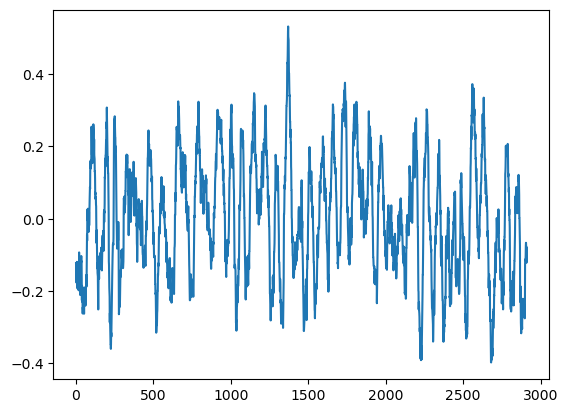

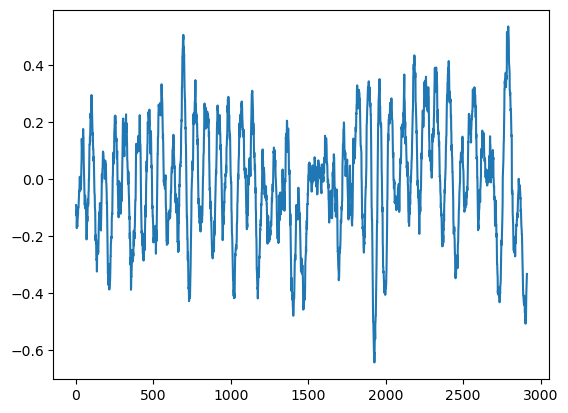

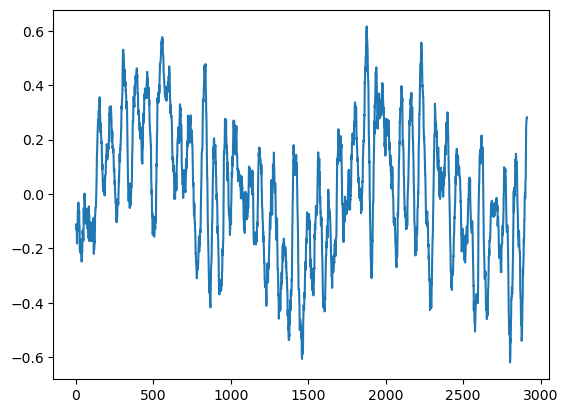

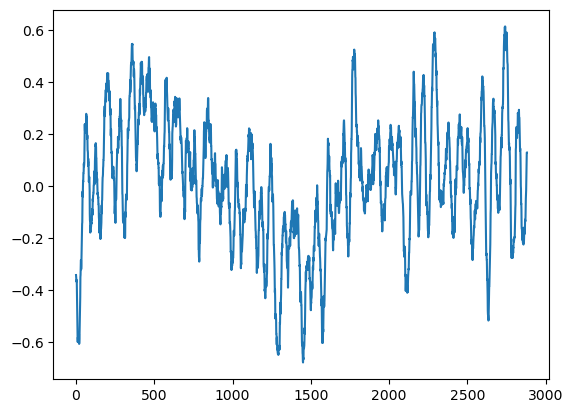

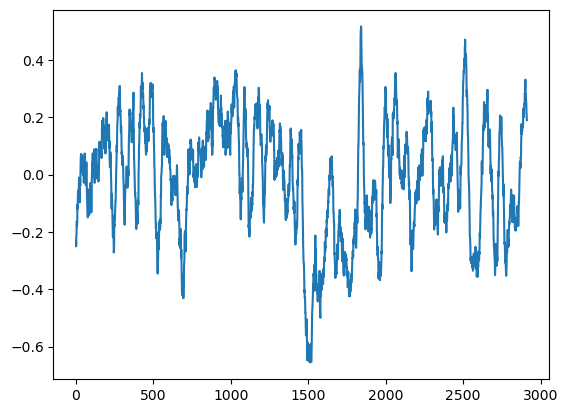

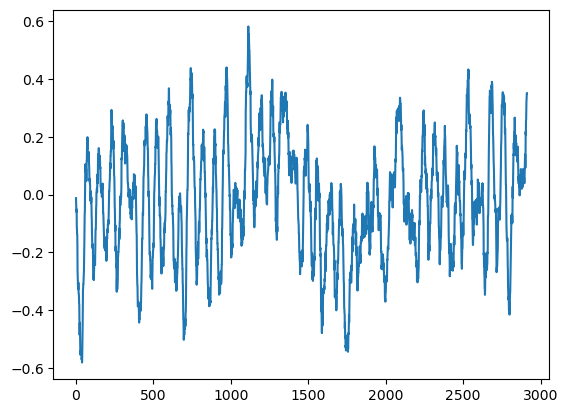

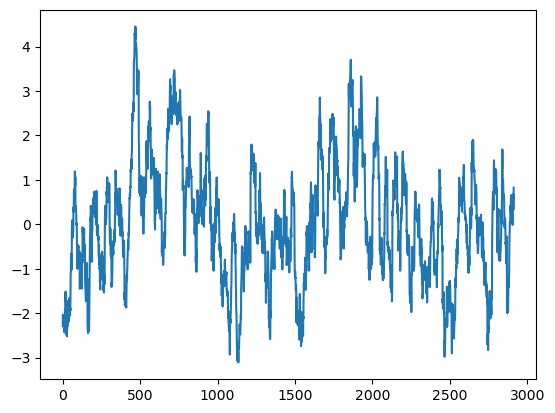

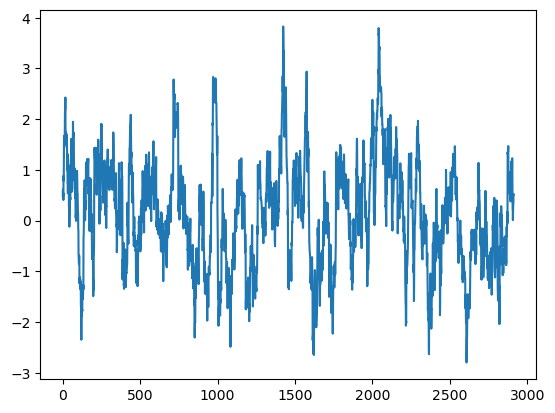

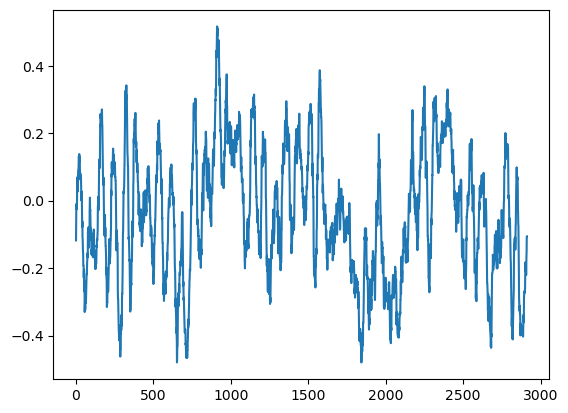

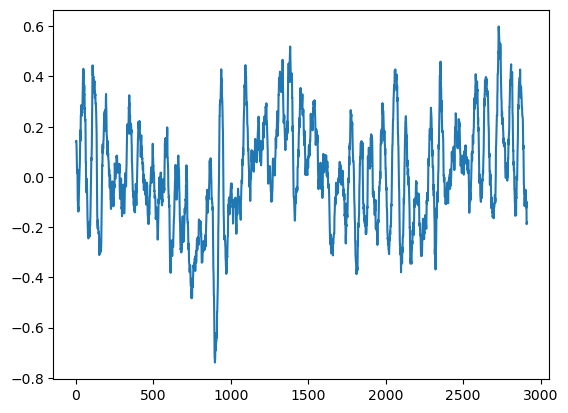

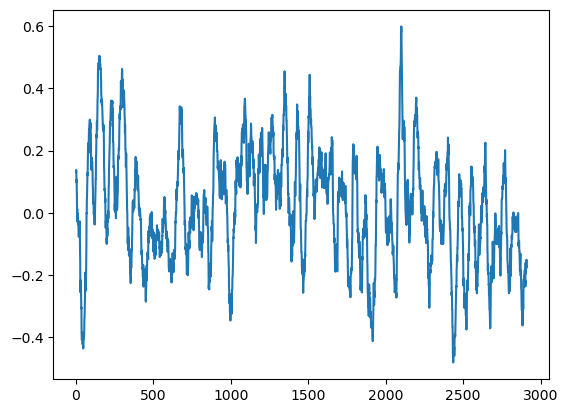

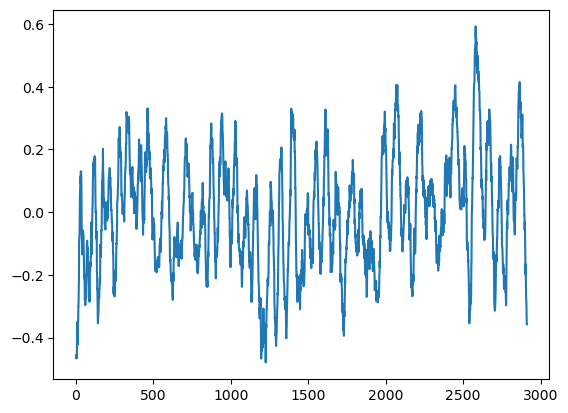

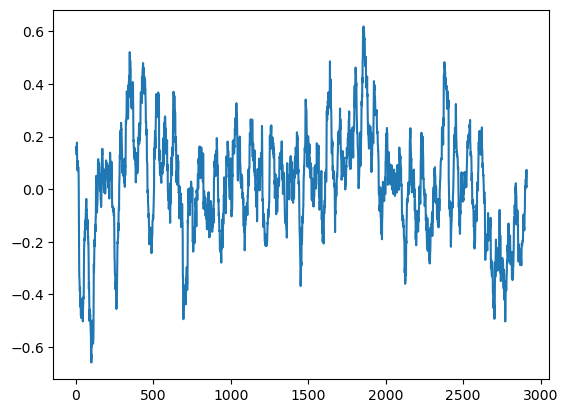

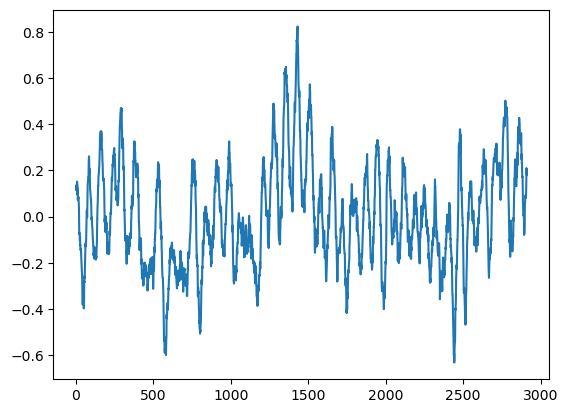

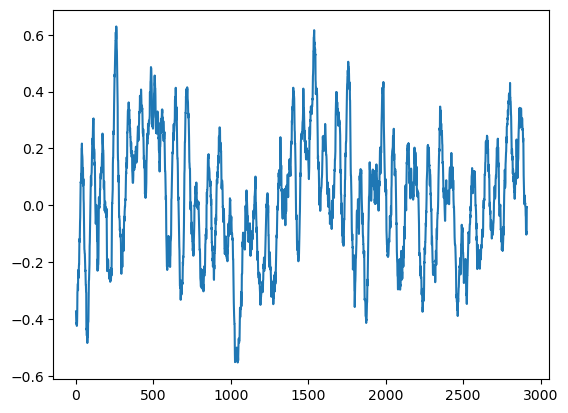

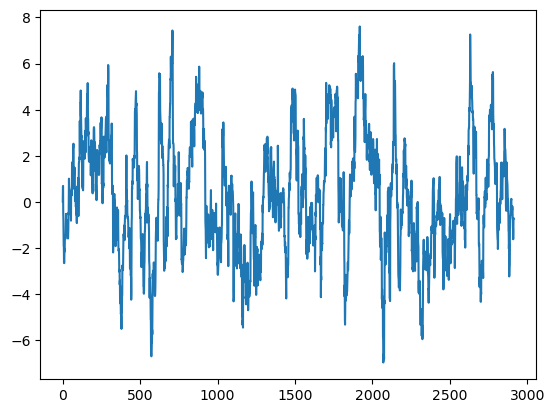

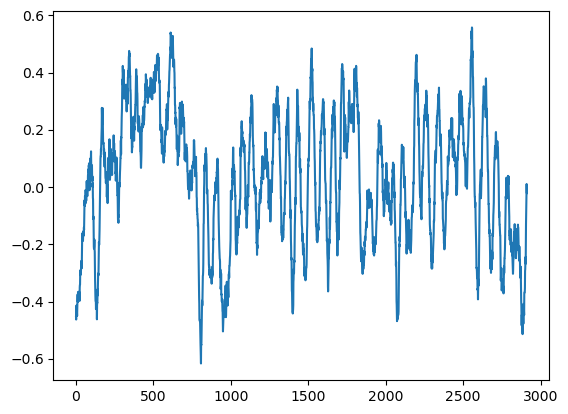

KeyboardInterrupt: 

In [111]:
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Periodic/'):
    make_spectrum(i)